In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

In [3]:
df= pd.read_csv('/content/drive/MyDrive/Q1_material_diabetic_data_final.csv')
features_df= df[['race','gender','age','weight','admission_type_id','discharge_disposition_id',
                 'admission_source_id','time_in_hospital','medical_specialty','num_lab_procedures',
                 'num_procedures','num_medications','number_outpatient','number_emergency','number_inpatient',
                 'number_diagnoses','max_glu_serum','A1Cresult','change','diabetesMed','readmitted'
                 ]]
medicine_df= df[['metformin','repaglinide','nateglinide','chlorpropamide','glimepiride','acetohexamide',
                 'glipizide','glyburide','tolbutamide','pioglitazone','rosiglitazone','acarbose',
                 'miglitol','troglitazone','tolazamide','examide','citoglipton','insulin','glyburide.metformin',
                 'glipizide.metformin','glimepiride.pioglitazone','metformin.rosiglitazone','metformin.pioglitazone'
                 ]]

<ipython-input-3-9090823bb42c>:1: DtypeWarning: Columns (6,11) have mixed types. Specify dtype option on import or set low_memory=False.
  df= pd.read_csv('/content/drive/MyDrive/Q1_material_diabetic_data_final.csv')


#### Data cleaning and preprosessing

Here the data has many null values. But removing those values will lead to too much loss of information. Hence we will impute those data missing data points.

In [4]:
features_df.isnull().sum() # Count of missing

,0
race,2273
gender,0
age,0
weight,20353
admission_type_id,0
discharge_disposition_id,0
admission_source_id,0
time_in_hospital,0
medical_specialty,49949
num_lab_procedures,0


In the dataset there are columns whcih have null values but they are replaced by some string. These points will also be imputed. Numerical values are imputed using their median and factor variables are replaced with either mode or a new factor called "Missing"/0.


In [65]:
from sklearn.impute import KNNImputer # Import KNNImputer
from sklearn.preprocessing import StandardScaler # Import StandardScaler for scaling before KNN imputation

# Perform the initial replacements for categorical/ID columns and prepare weight for imputation
features_df.loc[:,"gender"]=features_df["gender"].replace('Unknown/Invalid',"Missing")

# For ID columns, let's keep the previous strategy of replacing specific values with 0
# as KNNImputer is for numerical. If you strictly want to use KNN on ID columns,
# you would need to encode them first. We will apply KNN only to numerical columns.
features_df.loc[:, "admission_type_id"] = features_df["admission_type_id"].replace([5, 6, 8], 0)
features_df.loc[:, "discharge_disposition_id"] = features_df["discharge_disposition_id"].replace([18,25,26], 0)
features_df.loc[:, "admission_source_id"] = features_df["admission_source_id"].replace([9,17,20], 0)


# Replace string representations of missing values with "Missing"
features_df.loc[:, "max_glu_serum"] = features_df["max_glu_serum"].replace(np.nan, "Missing")
features_df.loc[:, "A1Cresult"] = features_df["A1Cresult"].replace(np.nan, "Missing")
features_df.loc[:,"race"]=features_df["race"].replace(np.nan,"Missing")
features_df.loc[:, "medical_specialty"] = features_df["medical_specialty"].replace(np.nan, "Missing")


# Prepare 'weight' for KNN imputation by ensuring np.nan for missing
# Original code already replaces string categories with np.nan
features_df.loc[:, "weight"] = features_df["weight"].replace(['[0-25)', '[25-50)', '[50-75)', '[75-100)', '[100-125)', '[125-150)', '[150-175)', '[175-200)', '>200'], np.nan)

# Identify numerical columns that might have NaNs after initial processing
numerical_cols_to_impute = features_df.select_dtypes(include=np.number).columns
# Check which of these actually have NaNs
numerical_cols_with_nan = numerical_cols_to_impute[features_df[numerical_cols_to_impute].isnull().any()]

print(f"Numerical columns with NaNs to impute using KNN: {list(numerical_cols_with_nan)}")

if len(numerical_cols_with_nan) > 0:
    scaler = StandardScaler()
    scaled_numerical_data = scaler.fit_transform(features_df[numerical_cols_with_nan])
    knn_imputer = KNNImputer(n_neighbors=5) # n_neighbors can be adjusted
    imputed_scaled_numerical_data = knn_imputer.fit_transform(scaled_numerical_data)
    features_df[numerical_cols_with_nan] = imputed_scaled_numerical_data

print("\nMissing values after imputation:")
print(features_df.isnull().sum())

# The features_df DataFrame now contains the imputed numerical values
# and the categorical columns processed according to the initial replacements.

<ipython-input-65-fef5e04b2cae>:24: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  features_df.loc[:, "weight"] = features_df["weight"].replace(['[0-25)', '[25-50)', '[50-75)', '[75-100)', '[100-125)', '[125-150)', '[150-175)', '[175-200)', '>200'], np.nan)


Numerical columns with NaNs to impute using KNN: []

Missing values after imputation:
race                             0
gender                           0
age                              0
weight                      101766
admission_type_id                0
discharge_disposition_id         0
admission_source_id              0
time_in_hospital                 0
medical_specialty                0
num_lab_procedures               0
num_procedures                   0
num_medications                  0
number_outpatient                0
number_emergency                 0
number_inpatient                 0
number_diagnoses                 0
max_glu_serum                    0
A1Cresult                        0
change                           0
diabetesMed                      0
readmitted                       0
dtype: int64


Fixing the datatypes appropriately

In [6]:
features_df.loc[:,'race']=features_df['race'].astype('category')
features_df.loc[:,'gender']=features_df['gender'].astype('category')
features_df.loc[:,'age']=features_df['age'].astype('category')
features_df.loc[:,'weight']=features_df['weight'].astype('float')
features_df.loc[:,'medical_specialty']=features_df['medical_specialty'].astype('category')
features_df.loc[:,'max_glu_serum']=features_df['max_glu_serum'].astype('category')
features_df.loc[:,'A1Cresult']=features_df['A1Cresult'].astype('category')
features_df.loc[:,'change']=features_df['change'].astype('category')
features_df.loc[:,'diabetesMed']=features_df['diabetesMed'].astype('category')
features_df.loc[:,'readmitted']=features_df['readmitted'].astype('category')
features_df.loc[:,'admission_type_id']=features_df['admission_type_id'].astype('category')
features_df.loc[:,'discharge_disposition_id']=features_df['discharge_disposition_id'].astype('category')
features_df.loc[:,'admission_source_id']=features_df['admission_source_id'].astype('category')

In [40]:
for col in medicine_df.columns:
    medicine_df[col] = medicine_df[col].astype('category')
medicine_df.dtypes

<ipython-input-40-3f8c6bb2dbd0>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  medicine_df[col] = medicine_df[col].astype('category')
<ipython-input-40-3f8c6bb2dbd0>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  medicine_df[col] = medicine_df[col].astype('category')
<ipython-input-40-3f8c6bb2dbd0>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pyd

,0
metformin,category
repaglinide,category
nateglinide,category
chlorpropamide,category
glimepiride,category
acetohexamide,category
glipizide,category
glyburide,category
tolbutamide,category
pioglitazone,category


In [41]:
Final_df = pd.concat([features_df, medicine_df], axis=1)

#### Exploratory Data Analysis
Here the response variable is 'readmitted' So we will try to find relationships between the features and the response and try to find patterns or trends

<ipython-input-55-384643b08b45>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=features_df, x='readmitted', palette='viridis')


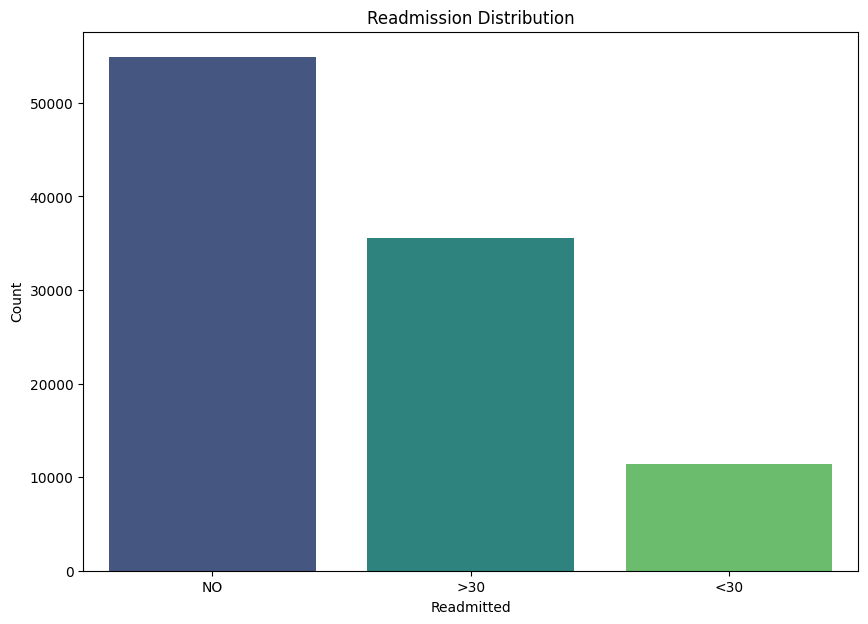

In [55]:
plt.figure(figsize=(10, 7))
sns.countplot(data=features_df, x='readmitted', palette='viridis')
plt.title('Readmission Distribution')
plt.xlabel('Readmitted')
plt.ylabel('Count')
plt.show()

<ipython-input-7-db094b49da3c>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=features_df, x='gender', palette='viridis')


Text(0, 0.5, 'Count')

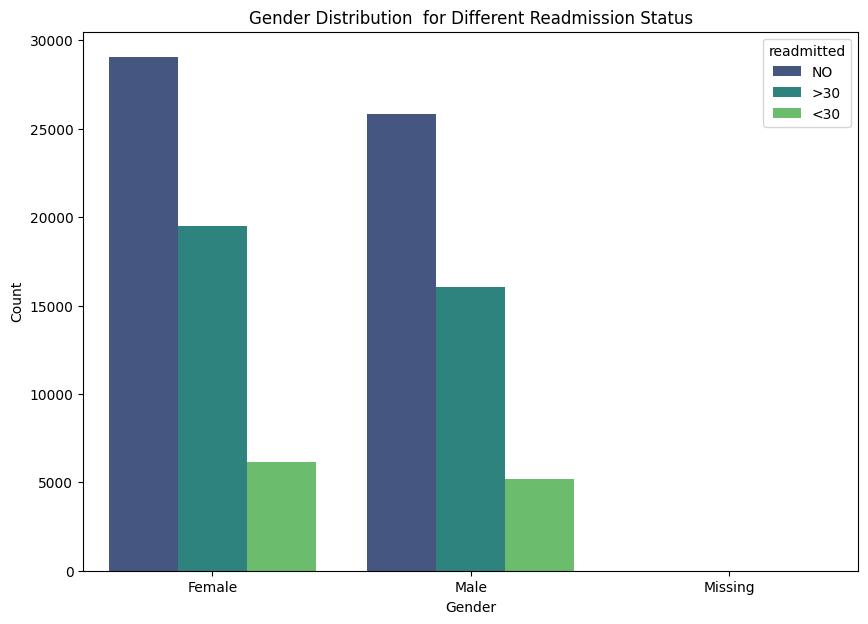

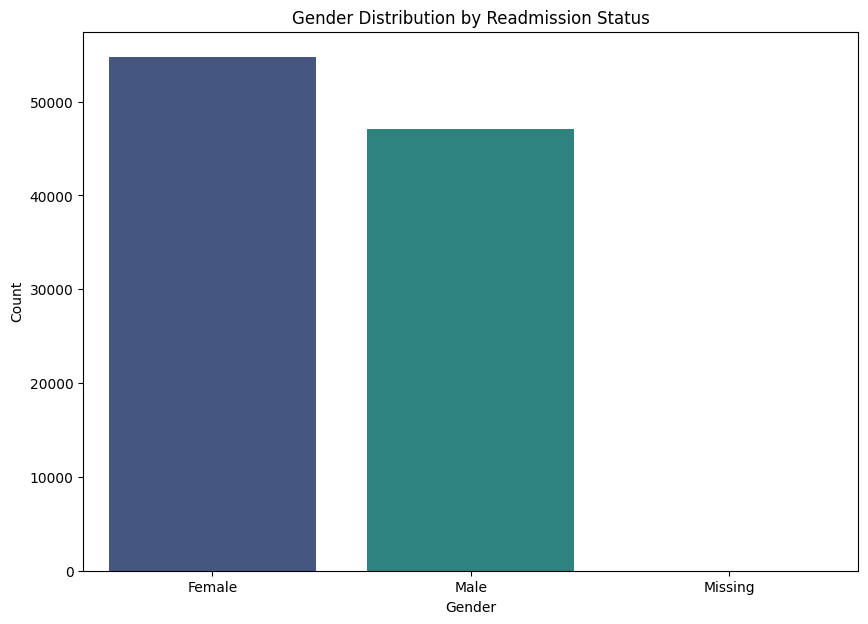

In [7]:
plt.figure(figsize=(10, 7))
sns.countplot(data=features_df, x='gender', hue='readmitted', palette='viridis')
plt.title('Gender Distribution  for Different Readmission Status')
plt.xlabel('Gender')
plt.ylabel('Count')

plt.figure(figsize=(10, 7))
sns.countplot(data=features_df, x='gender', palette='viridis')
plt.title('Gender Distribution by Readmission Status')
plt.xlabel('Gender')
plt.ylabel('Count')

<ipython-input-8-ec06fd35b023>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=features_df, x='race', palette='viridis')


Text(0, 0.5, 'Count')

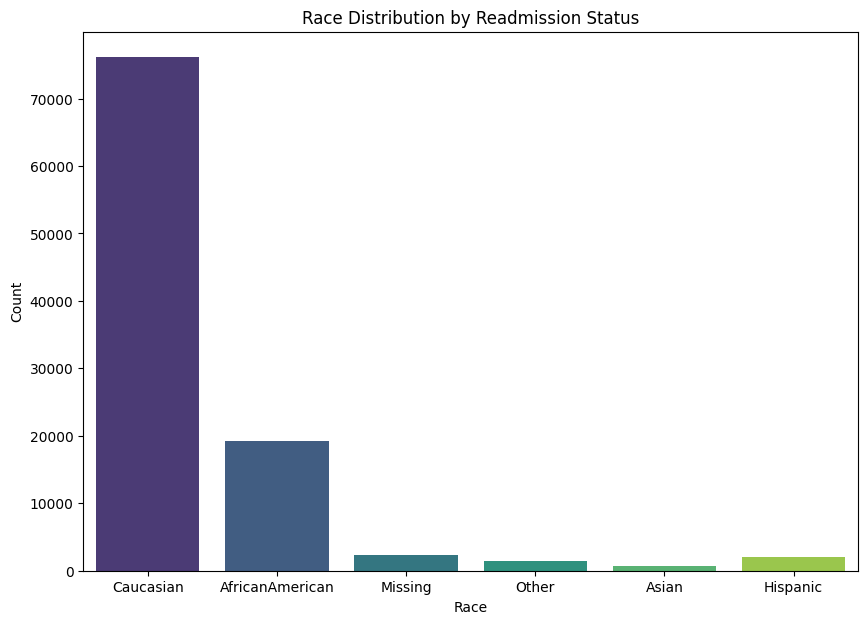

In [8]:
plt.figure(figsize=(10, 7))
sns.countplot(data=features_df, x='race', palette='viridis')
plt.title('Race Distribution by Readmission Status')
plt.xlabel('Race')
plt.ylabel('Count')

<ipython-input-9-39e6193f7faf>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=features_df, x='admission_type_id', palette='viridis')


Text(0, 0.5, 'Count')

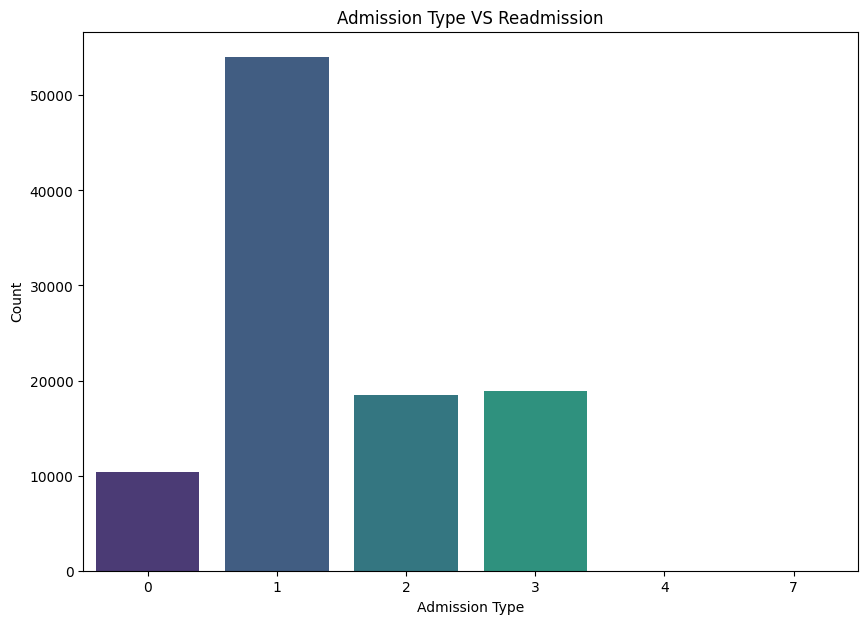

In [9]:
plt.figure(figsize=(10, 7))
sns.countplot(data=features_df, x='admission_type_id', palette='viridis')
plt.title('Admission Type VS Readmission')
plt.xlabel('Admission Type')
plt.ylabel('Count')

<ipython-input-10-dead9a86b7fe>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=features_df, x='admission_source_id', palette='viridis')


Text(0, 0.5, 'Count')

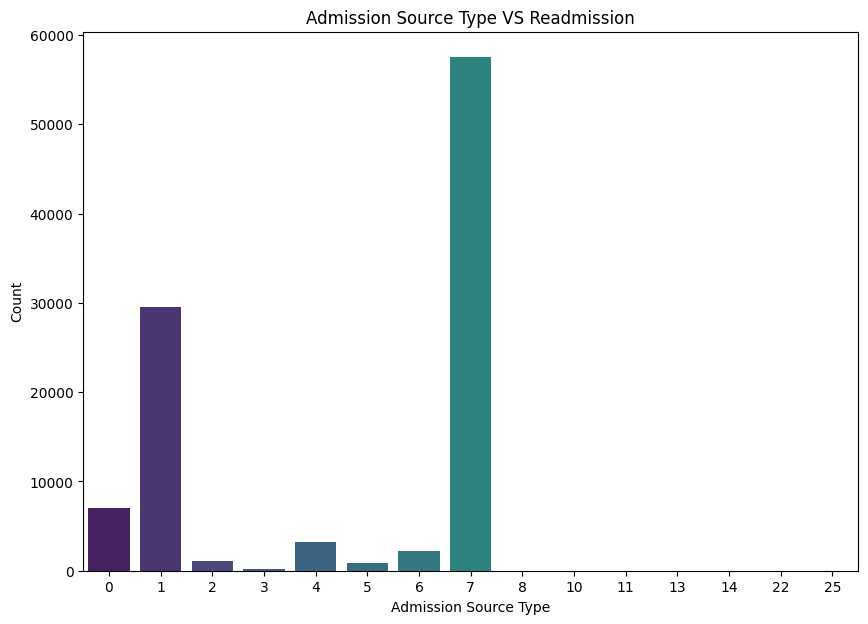

In [10]:
plt.figure(figsize=(10, 7))
sns.countplot(data=features_df, x='admission_source_id', palette='viridis')
plt.title('Admission Source Type VS Readmission')
plt.xlabel('Admission Source Type')
plt.ylabel('Count')

<ipython-input-11-62b8b0cc42e1>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=features_df, x='discharge_disposition_id', palette='viridis')


Text(0, 0.5, 'Count')

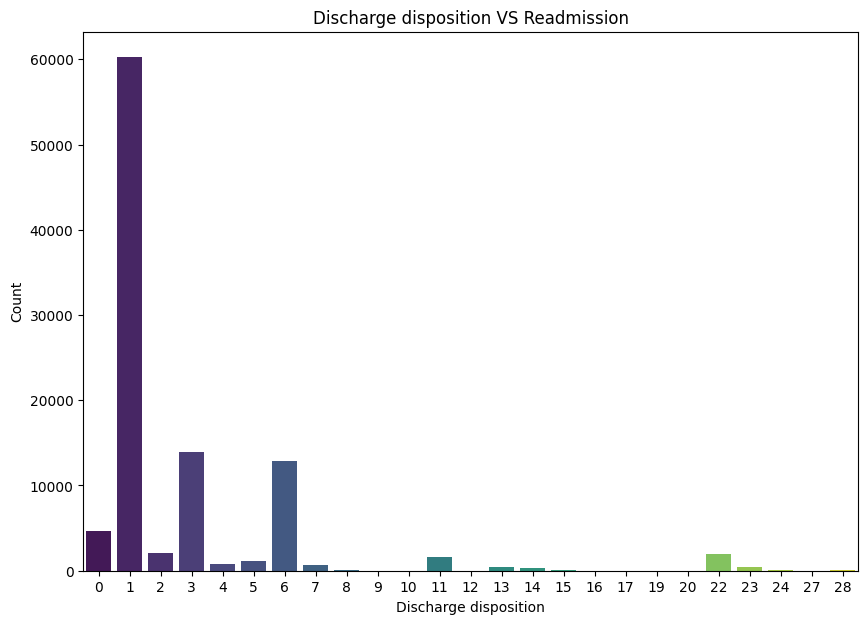

In [11]:
plt.figure(figsize=(10, 7))
sns.countplot(data=features_df, x='discharge_disposition_id', palette='viridis')
plt.title('Discharge disposition VS Readmission')
plt.xlabel('Discharge disposition')
plt.ylabel('Count')

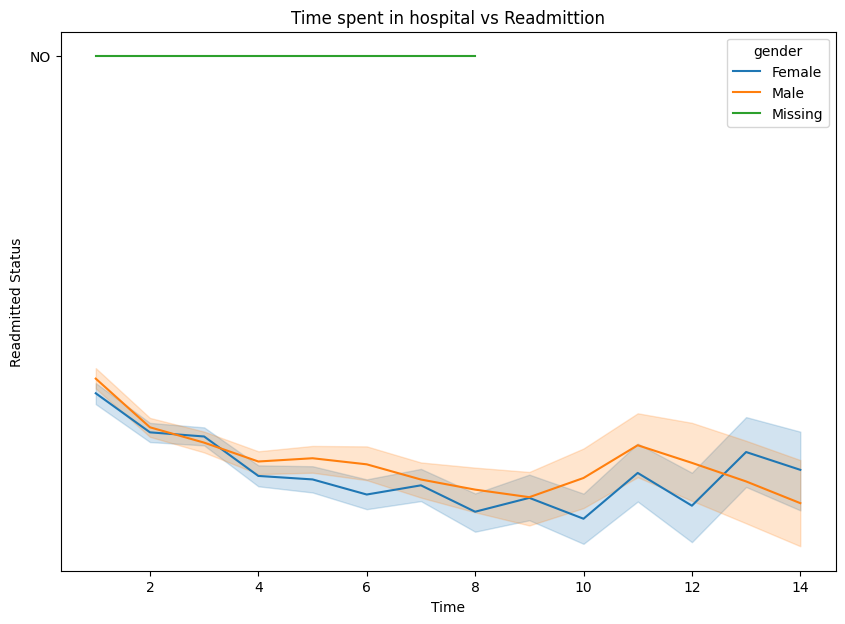

In [12]:
plt.figure(figsize=(10, 7))
# Create the line plot
sns.lineplot(data=features_df, y='readmitted', x='time_in_hospital',hue= 'gender')
plt.title('Time spent in hospital vs Readmittion') # Appropriate title for a line plot of means
plt.ylabel('Readmitted Status')
plt.xlabel('Time')
plt.show()

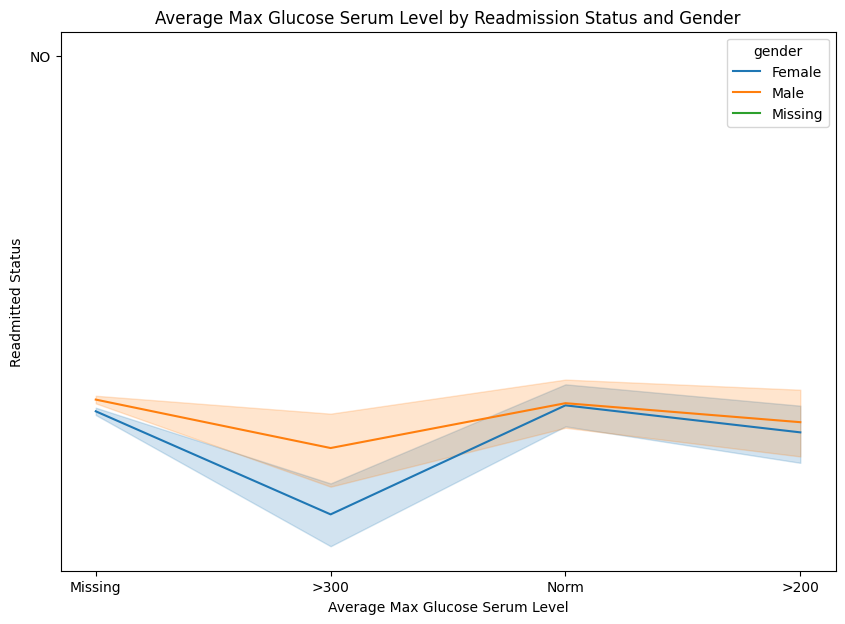

In [13]:
plt.figure(figsize=(10, 7))
sns.lineplot(data=features_df, x='max_glu_serum', y='readmitted', hue='gender')
plt.title('Average Max Glucose Serum Level by Readmission Status and Gender')
plt.xlabel('Average Max Glucose Serum Level')
plt.ylabel('Readmitted Status')
plt.show()

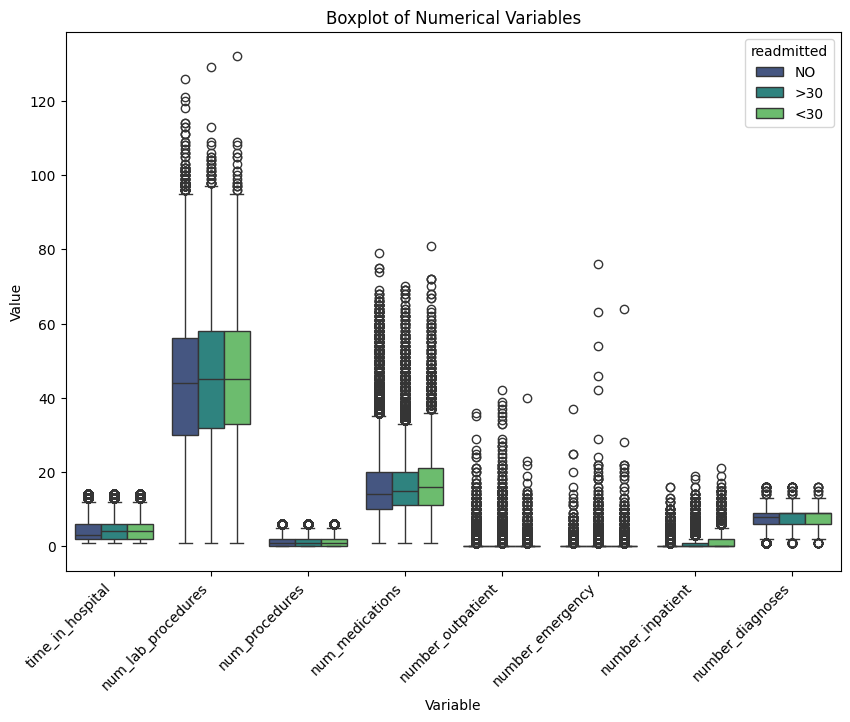

In [14]:
numerical_df= features_df[['time_in_hospital','num_lab_procedures','num_procedures','num_medications',
                           'number_outpatient','number_emergency','number_inpatient','number_diagnoses','readmitted']].melt(id_vars='readmitted')

plt.figure(figsize=(10,7))
sns.boxplot(data= numerical_df,x='variable',y='value',hue= 'readmitted',palette= 'viridis')
plt.title('Boxplot of Numerical Variables')
plt.xlabel('Variable')
plt.ylabel('Value')
plt.xticks(rotation= 45, ha= 'right')
plt.legend(title= 'readmitted')
plt.show()

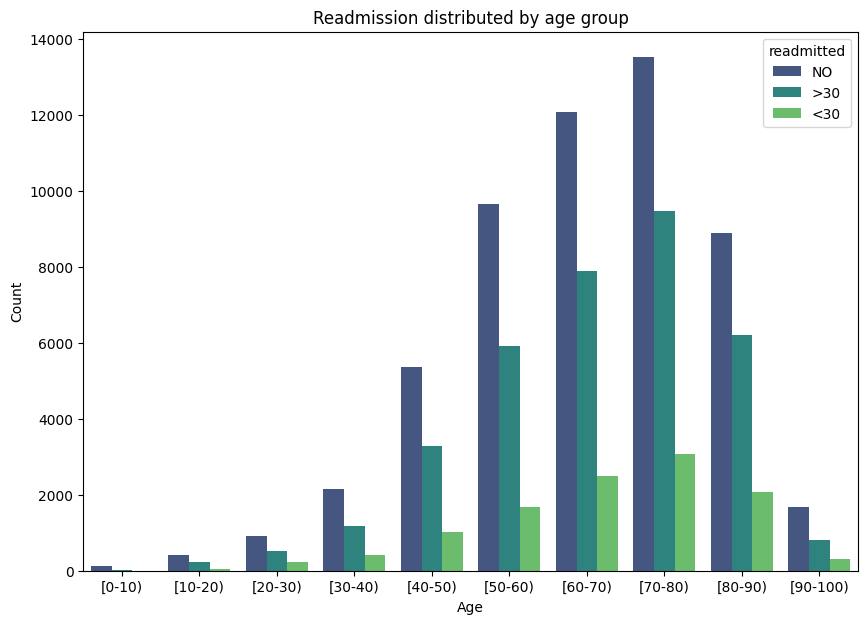

In [15]:
plt.figure(figsize=(10,7))
sns.countplot(data= features_df,x= 'age',hue= 'readmitted',palette='viridis')
plt.title("Readmission distributed by age group")
plt.xlabel("Age")
plt.ylabel("Count")
plt.show()

##### Key findings from EDA:
- Females have slightly higher readmission count. i.e. females areslightly more likely to be readmitted.

- Caucasions have the highest readmission count.

- Patients who are discharged to home are more likely to be readmitted.

- There is no pattern between time spent in hospital and readmission i.e. time span in hospital has nothing to do with the readmission.

- The boxplots show that those patents on whom most lab procedures are performed they are more likely to be readmitted.

- The age group 70-80 have the highest readmission case.

#### Feature selection, Model fitting and validation

Here we will use LASSO for feature selection and then we will fit a tree based model to the data

In [66]:
#Train-test split
from sklearn.model_selection import train_test_split
X= Final_df.drop('readmitted',axis=1)
y= Final_df['readmitted']
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = X.select_dtypes(include=['object']).columns
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [67]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols), # Scale numerical features
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols) # One-hot encode categorical features
    ])

clf_model = Pipeline(steps=[('preprocessor', preprocessor),
                        ('classifier', DecisionTreeClassifier(random_state=42, max_depth=5)) # Add pruning for max_depth
                       ])

clf_model.fit(X_train,y_train)
predictions= clf_model.predict(X_test)

In [68]:
#Model evaluation
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
accuracy= accuracy_score(y_test,predictions)
print(f"Accuracy of model is: {accuracy}")
precision_scores = precision_score(y_test, predictions, average=None)
classes = sorted(y_test.unique())

# Find the index of the 'NO' class
try:
    no_class_index = classes.index('NO')
except ValueError:
    print("Warning: 'NO' class not found in y_test. Cannot calculate precision for 'NO'.")
    no_class_index = None

# Get the precision for the 'NO' class if found
if no_class_index is not None:
    precision = precision_scores[no_class_index]
    print(f"Precision for 'NO' class: {precision}")
else:
    # Handle the case where 'NO' is not in the classes (e.g., assign a default value or skip)
    precision = None # Or some other appropriate handling

if no_class_index is not None:
    recall_scores= recall_score(y_test,predictions,average= None)
    recall= recall_scores[no_class_index]
    print(f"Recall for 'NO' class: {recall}")
else:
    recall= None



Accuracy of model is: 0.5757590645573352
Precision for 'NO' class: 0.6150299359988989
Recall for 'NO' class: 0.8160153396639883


In [69]:
from sklearn.linear_model import LogisticRegression

# Define the Logistic Regression model pipeline
logit_model = Pipeline(steps=[('preprocessor', preprocessor),
                               ('classifier', LogisticRegression(multi_class='auto', solver='lbfgs', max_iter=1000, random_state=42)) # Multiclass Logistic Regression
                              ])

# Fit the model
logit_model.fit(X_train, y_train)

# Make predictions
logit_predictions = logit_model.predict(X_test)

# You can now evaluate the logreg_predictions using appropriate metrics for multiclass classification
# For example:
from sklearn.metrics import  classification_report
accuracy_logreg= accuracy_score(y_test,logit_predictions)
print(f"Accuracy of model is: {accuracy_logreg}")
print("\nClassification Report:")
print(classification_report(y_test, logit_predictions))

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Accuracy of model is: 0.5712881988798271

Classification Report:
              precision    recall  f1-score   support

         <30       0.39      0.01      0.02      2285
         >30       0.50      0.26      0.34      7117
          NO       0.59      0.89      0.71     10952

    accuracy                           0.57     20354
   macro avg       0.49      0.39      0.36     20354
weighted avg       0.53      0.57      0.50     20354



In [70]:
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder

numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = X.select_dtypes(include=['object', 'category']).columns # Include 'category' dtype for categorical columns

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

num_classes = len(label_encoder.classes_) # Get the number of unique classes after encoding

xgb_model = Pipeline(steps=[('preprocessor', preprocessor),
                             ('classifier', xgb.XGBClassifier(objective='multi:softmax',  # Multiclass objective
                                                              num_class=num_classes,      # Number of unique classes
                                                              eval_metric='mlogloss',    # Evaluation metric for multiclass
                                                              use_label_encoder=False,   # Suppress warning
                                                              random_state=42))
                            ])
xgb_model.fit(X_train, y_train_encoded)
xgb_predictions = xgb_model.predict(X_test)
accuracy_xgb= accuracy_score(y_test_encoded,xgb_predictions)
print(f"Accuracy: {accuracy_xgb}")

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [15:23:16] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 0.5904490517834332


In [71]:
from sklearn.ensemble import RandomForestClassifier

# Define the Random Forest Classifier model pipeline
rf_model = Pipeline(steps=[('preprocessor', preprocessor), # Use the same preprocessor
                           ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
                          ])


rf_model.fit(X_train, y_train)
rf_predictions = rf_model.predict(X_test)

accuracy_rf = accuracy_score(y_test, rf_predictions)
print(f"Random Forest Accuracy: {accuracy_rf}")

print("\nRandom Forest Classification Report:")
print(classification_report(y_test, rf_predictions))

Random Forest Accuracy: 0.5740886312272772

Random Forest Classification Report:
              precision    recall  f1-score   support

         <30       0.30      0.02      0.05      2285
         >30       0.49      0.40      0.44      7117
          NO       0.61      0.80      0.70     10952

    accuracy                           0.57     20354
   macro avg       0.47      0.41      0.39     20354
weighted avg       0.53      0.57      0.53     20354



In [73]:

# Access the fitted Logistic Regression classifier from the unweighted pipeline
logistic_reg_classifier = logit_model.named_steps['classifier']


# Get the feature names generated by the preprocessor.
# This method requires scikit-learn version 1.0 or higher.
try:
    feature_names = preprocessor.get_feature_names_out()

    # --- Unweighted Logistic Regression Coefficients ---
    print("\nCoefficients for unweighted Logistic Regression:")

    # Check if the model is multiclass or binary
    if len(logistic_reg_classifier.classes_) > 2:
        # Multiclass classification
        for i, class_name in enumerate(logistic_reg_classifier.classes_):
            print(f"\nClass: {class_name}")
            coefficients = pd.DataFrame({
                'Feature': feature_names,
                'Coefficient': logistic_reg_classifier.coef_[i]
            })
            # Print top N positive and negative coefficients for insight
            print("Top 5 Positive Coefficients:")
            print(coefficients.sort_values(by='Coefficient', ascending=False).head())
            print("\nTop 5 Negative Coefficients:")
            print(coefficients.sort_values(by='Coefficient', ascending=True).head())
    else:
        # Binary classification
         coefficients = pd.DataFrame({
             'Feature': feature_names,
             'Coefficient': logistic_reg_classifier.coef_[0]
         })
         # Print top N positive and negative coefficients for insight
         print("Top 5 Positive Coefficients:")
         print(coefficients.sort_values(by='Coefficient', ascending=False).head())
         print("\nTop 5 Negative Coefficients:")
         print(coefficients.sort_values(by='Coefficient', ascending=True).head())

except AttributeError:
    print("Could not get feature names using get_feature_names_out(). This might be due to an older scikit-learn version.")
    print("You will need to manually reconstruct feature names after one-hot encoding if needed.")
    # Fallback: Print coefficients without feature names
    print("\nUnweighted Logistic Regression Coefficients (without feature names):")
    print(logistic_reg_classifier.coef_)


Coefficients for unweighted Logistic Regression:

Class: <30
Top 5 Positive Coefficients:
                                       Feature  Coefficient
45           cat__medical_specialty_Hematology     0.732289
46  cat__medical_specialty_Hematology/Oncology     0.467473
84            cat__medical_specialty_Radiology     0.439483
57             cat__medical_specialty_Oncology     0.331612
48   cat__medical_specialty_InfectiousDiseases     0.331500

Top 5 Negative Coefficients:
                                            Feature  Coefficient
62            cat__medical_specialty_Otolaryngology    -0.553982
69  cat__medical_specialty_Pediatrics-Endocrinology    -0.466162
81                cat__medical_specialty_Psychology    -0.404859
44                cat__medical_specialty_Gynecology    -0.399740
52                 cat__medical_specialty_Neurology    -0.388389

Class: >30
Top 5 Positive Coefficients:
                                           Feature  Coefficient
73   cat__medical_specia

In [75]:
# Access the fitted XGBoost classifier from the pipeline
xgb_classifier = xgb_model.named_steps['classifier']

try:
    feature_names = preprocessor.get_feature_names_out()
    if hasattr(xgb_classifier, 'feature_importances_'):
        if len(feature_names) == len(xgb_classifier.feature_importances_):
             feature_importances_xgb = pd.DataFrame({
                 'Feature': feature_names,
                 'Importance': xgb_classifier.feature_importances_
             })
             print(feature_importances_xgb.sort_values(by='Importance', ascending=False).head(10)) # Print top 10 important features
        else:
            print("Warning: Number of preprocessed features does not match XGBoost importance array length.")
            print("XGBoost Feature Importances (indices):")
            print(xgb_classifier.feature_importances_) # Print importances without feature names/mapping
    else:
        print("XGBoost classifier does not have 'feature_importances_' attribute. Check booster type.")
        # If booster='gblinear', coefficients are available via .coef_
        if hasattr(xgb_classifier, 'coef_'):
             print("\nXGBoost (gblinear booster) Coefficients:")
             # Handle multi-class if necessary
             if len(xgb_classifier.classes_) > 2:
                 for i, class_name in enumerate(xgb_classifier.classes_):
                     print(f"\nClass: {class_name}")
                     coefficients_xgb = pd.DataFrame({
                        'Feature': feature_names, # Assuming feature_names match for gblinear
                        'Coefficient': xgb_classifier.coef_[i]
                     })
                     print("Top 5 Positive Coefficients:")
                     print(coefficients_xgb.sort_values(by='Coefficient', ascending=False).head())
                     print("\nTop 5 Negative Coefficients:")
                     print(coefficients_xgb.sort_values(by='Coefficient', ascending=True).head())
             else:
                coefficients_xgb = pd.DataFrame({
                    'Feature': feature_names, # Assuming feature_names match for gblinear
                    'Coefficient': xgb_classifier.coef_[0]
                })
                print("Top 5 Positive Coefficients:")
                print(coefficients_xgb.sort_values(by='Coefficient', ascending=False).head())
                print("\nTop 5 Negative Coefficients:")
                print(coefficients_xgb.sort_values(by='Coefficient', ascending=True).head())

        else:
             print("Could not retrieve feature importances or coefficients from XGBoost model.")


except AttributeError:
    print("Could not get feature names using get_feature_names_out(). This might be due to an older scikit-learn version.")
    print("Printing raw XGBoost feature importances (if available):")
    xgb_classifier = xgb_model.named_steps['classifier']
    if hasattr(xgb_classifier, 'feature_importances_'):
         print(xgb_classifier.feature_importances_)
    elif hasattr(xgb_classifier, 'coef_'):
         print("\nXGBoost (gblinear booster) Coefficients (without feature names):")
         print(xgb_classifier.coef_)
    else:
         print("Could not retrieve feature importances or coefficients from XGBoost model.")

                                            Feature  Importance
9                             num__number_inpatient    0.100820
1                     num__discharge_disposition_id    0.040074
2                          num__admission_source_id    0.022201
113                             cat__diabetesMed_No    0.021639
10                            num__number_diagnoses    0.019369
8                             num__number_emergency    0.018461
7                            num__number_outpatient    0.018268
56   cat__medical_specialty_ObstetricsandGynecology    0.017178
105                      cat__max_glu_serum_Missing    0.016307
39          cat__medical_specialty_Emergency/Trauma    0.015988
